In [6]:
# Imports

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# Load data
mat_file = loadmat('data/test-data/000.mat')

KeyboardInterrupt: 

(4, 1500)


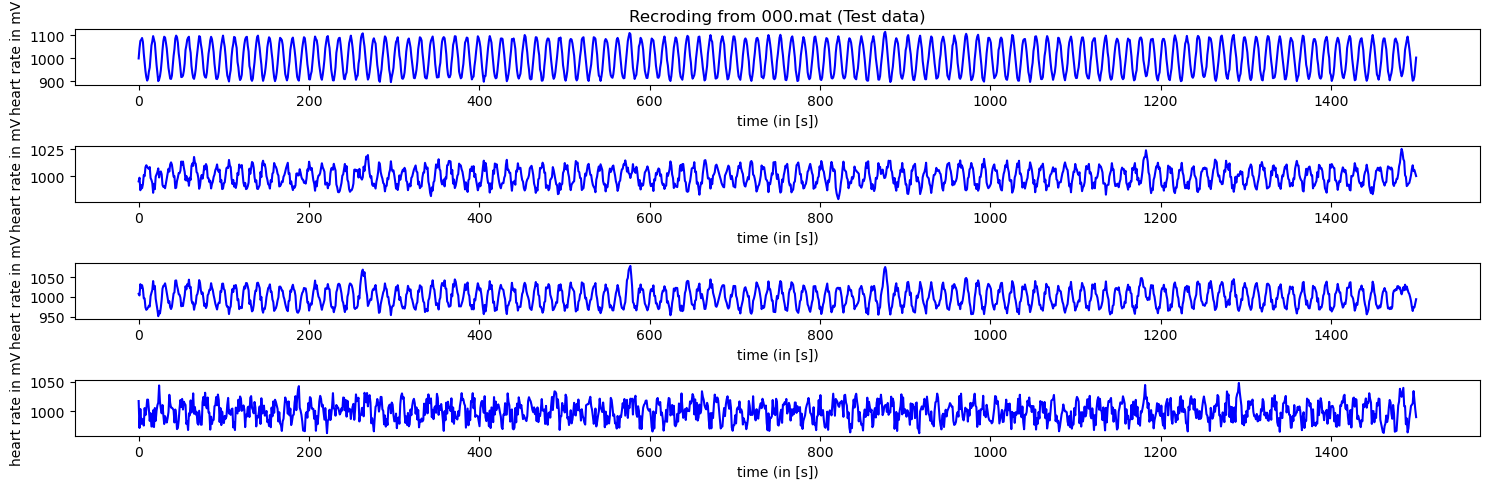

In [11]:
data00 = mat_file['val'].reshape(4,-1)

print(data00.shape)

fig, ax = plt.subplots(4,1, figsize=(15,5))


x = np.linspace(0, data00.shape[1], data00.shape[1])

for i in range(0,4):
    ax[i].plot(x, data00[i, :], color='blue', label=f'electrode {i}')
    ax[i].set_xlabel('time (in [s])')
    ax[i].set_ylabel('heart rate in mV')

ax[0].set_title('Recroding from 000.mat (Test data)')


plt.tight_layout()
plt.show()

